<a href="https://colab.research.google.com/github/Mike030668/MIPT_magistratura/blob/main/ModNets/Latent/DZ_1_latent_diffusion_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Домашнее задание: реализация модели latent diffusion

In [ ]:
import torch
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!pip install diffusers[training] -q

!pip install accelerate -q
!pip install -qq diffusers==0.11.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.9/524.9 kB 11.7 MB/s eta 0:00:00


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

### [3 балла] Реализация обучения модели latent diffusion

Напоминание про реализацию модели [Latent Diffusion](https://nn.labml.ai/diffusion/stable_diffusion/latent_diffusion.html)

Для того, чтобы из кода обучения Diffusion получить обучения Latent Diffusion, вам нужно добавить VQ-VAE и заморозить! и обрабатывать изображения с помощью `vae.encode`. Далее полученные latent, подаются в стандартный пайплайн обучения. Учтите, что latent имеет меньшую размерность и вам может понадобиться уменьшить число слоёв в архитектуре UNet.

В качестве модели VQ-VAE вы можете воспользоваться предобученным VQ-VAE от Stable diffusion.

**Ожидаемый результат**

В качестве результатов модели, от вас требуется предоставить визуализации генераций, полученных от вашей модели, и код обучения модели.

In [ ]:
BASE_PATH = '/content/drive/Othercomputers/My_comp/Documents/МФТИ - Наука о данных/Современные модели DL/Latent/'

In [ ]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 512  # сгенерированное разрешение изображения
    train_batch_size = 4
    eval_batch_size = 4  # сколько изображений мы можем сэмплировать во время eval
    num_epochs = 15
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 1
    save_model_epochs = 1
    mixed_precision = 'fp16'  # `no` для float32, `fp16` для автоматической смешанной точности
    output_dir = BASE_PATH + 'flowers-512'  # имя модели локально и на HF Hub
    push_to_hub = False  # Если True, то загружаем сохраненную модель в HF Hub
    hub_private_repo = False
    overwrite_output_dir = True  # Если True, то перезаписываем старую модель при повторном запуске ноутбука
    seed = 0

config = TrainingConfig()

In [ ]:
config.eval_batch_size

4

## Загрузка набора данных

Мы будем использовать библиотеку [🤗 Datasets](https://github.com/huggingface/datasets) для загрузки нашего набора данных изображений.

В этом случае [набор данных Butterflies](https://huggingface.co/datasets/huggan/smithsonian_butterflies_subset) размещается удаленно, но вы можете загрузить локальную папку [ImageFolder](https://huggingface.co/docs/datasets/v2.0.0/en/image_process#imagefolder), как показано в комментариях ниже.

In [ ]:
!pip install datasets -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.1 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset

# Можно загрузить другие датасеты из https://hf.co/huggan/
# Например датасет с фотографиями цветков:
config.dataset_name = "huggan/flowers-102-categories" #"BirdL/DALL-E-Dogs" #
dataset = load_dataset(config.dataset_name, split="train")

# Или можете загрузить свой датасет
# config.dataset_name = name
# dataset = load_dataset(config.dataset_name, data_dir=path)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/8189 [00:00<?, ? examples/s]

Набор данных содержит разные признаки, но нас интересует `image`:

In [ ]:
dataset

Dataset({
    features: ['image'],
    num_rows: 8189
})

In [ ]:
dataset = dataset.rename_column('image', "images")
dataset

Dataset({
    features: ['images'],
    num_rows: 8189
})

In [ ]:
import gc
gc.collect()

237

# Preprocess data

Поскольку [`Image`](https://huggingface.co/docs/datasets/image_process#image-datasets) загружает изображения с помощью PIL, мы можем легко рассмотреть несколько примеров:

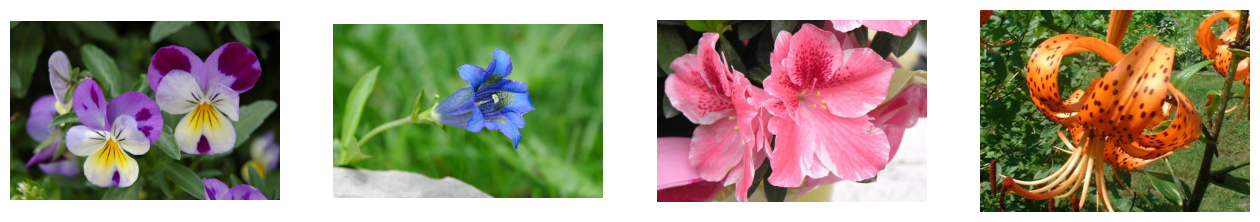

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["images"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

Все изображения в наборе данных разные, поэтому нам нужно сначала их предварительно обработать:
* `Resize` приводит изображения в соответствие с квадратным разрешением `config.image_size`.
* `RandomHorizontalFlip` дополняет набор данных, случайным образом зеркалируя изображения.
* `Normalize` важен для изменения масштаба значений пикселей в диапазон `[-1, 1]` (чего и ожидает наша модель).

In [ ]:
from torchvision import transforms

preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        #transforms.RandomVerticalFlip(p = 0.25),
        #transforms.RandomRotation((0,8)),
        transforms.RandomAffine(degrees = 2),
        transforms.ColorJitter(),
        transforms.RandomInvert(),
        transforms.RandomAutocontrast(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

🤗 Наборы данных предлагают удобный метод set_transform() для применения преобразований изображений «на лету» во время обучения:

In [ ]:
def transform(examples):
    images = [preprocess(image) for image in examples["images"]] #.convert("RGB")
    return {"images": images}

dataset.set_transform(transform)

Давайте посмотрим, как они выглядят сейчас

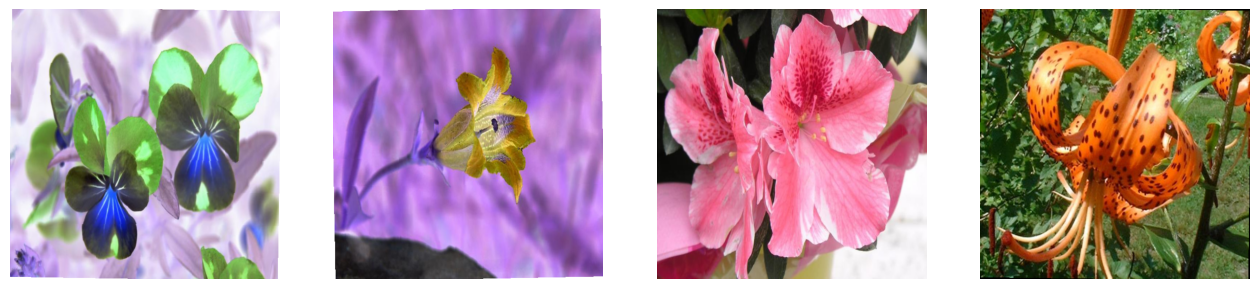

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["images"]):
    axs[i].imshow(image.permute(1, 2, 0).numpy() / 2 + 0.5)
    axs[i].set_axis_off()
fig.show()

# Accelerator and VAE

In [ ]:
from accelerate import Accelerator

In [ ]:
from diffusers import AutoencoderKL

VAE = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")#.to(DEVICE)

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

(…)fusion-v1-4/resolve/main/vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


Теперь, когда все наши изображения имеют одинаковый размер и преобразованы в тензоры, мы можем создать dataloader, который будем использовать для обучения.

In [ ]:
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

In [ ]:
accelerator = Accelerator()#fp16=True)
train_dataloader, VAE = accelerator.prepare(train_dataloader, VAE)

In [ ]:
dataiter = iter(train_dataloader)
sample_batch = next(dataiter)
sample_batch['images'].shape

torch.Size([4, 3, 512, 512])

In [ ]:
fig, axs = plt.subplots(1, sample_batch['images'].shape[0], figsize=(16, 4))
for i, image in enumerate(sample_batch['images']):
    axs[i].imshow(image.permute(1, 2, 0).cpu().numpy() / 2 + 0.5)
    axs[i].set_axis_off()
fig.show()

In [ ]:
def encode_vae(img):
    with torch.no_grad():
        diag_gaussian_distrib_obj = VAE.encode(img, return_dict=False)
        img_latent = diag_gaussian_distrib_obj[0].sample().detach().cpu()
        img_latent *= 0.18215
    return img_latent

img_latent = encode_vae(sample_batch['images']) #sample_tensor[None,::])
img_latent.shape

torch.Size([4, 4, 64, 64])

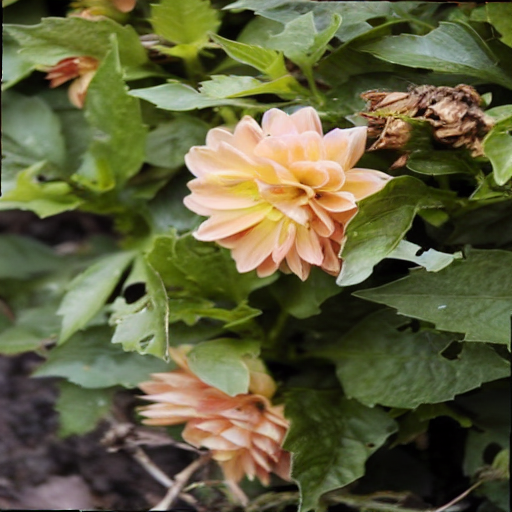

In [ ]:
from PIL import Image, ImageDraw
def decode_latents(latents):
    latents = 1 / 0.18215 * latents
    latents = latents.to(VAE.device)
    #print(latents.shape)

    with torch.no_grad():
        images = VAE.decode(latents)['sample']
    #print(images.shape)
    images = (images / 2 + 0.5).clamp(0, 1)
    #print(images.shape)
    images = images.detach().cpu().permute(0, 2, 3, 1).numpy()
    #print(images.shape)
    images = (images * 255).round().astype('uint8')
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

decode_images = decode_latents(img_latent)
decode_images[0]

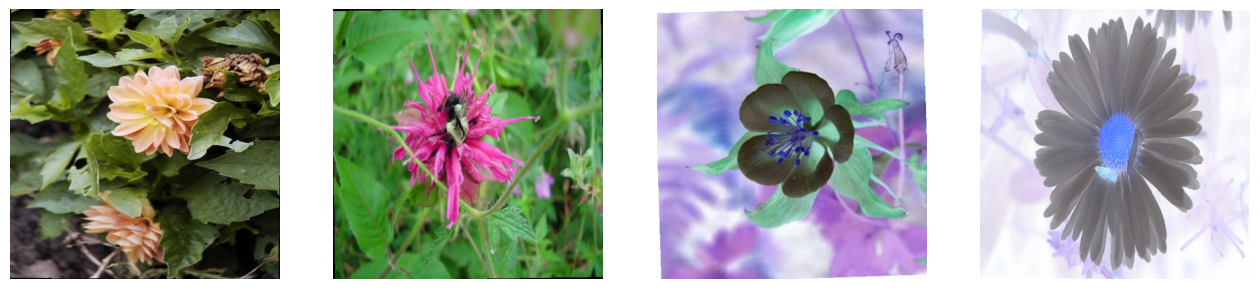

In [ ]:
fig, axs = plt.subplots(1, len(decode_images), figsize=(16, 4))
for i, image in enumerate(decode_images):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

# Build model

In [ ]:
from diffusers import UNet2DModel


model = UNet2DModel(
    sample_size=64,  # разрешение таргетного изображения
    in_channels=4,  # количество входных каналов, 3 для RGB изображений
    out_channels=4,  # количество выходных каналов
    layers_per_block=3,  # сколько ResNet слоев использовать для каждого UNet блока
    block_out_channels=(128, 128, 256, 256, 512),  # количество выходных каналов для каждого UNet блока
    down_block_types=(
        "DownBlock2D",  # обычный ResNet блок понижения дискретизации
        "AttnDownBlock2D",  # ResNet блок понижения дискретизации с самовниманием
        #"DownBlock2D",
        #"AttnDownBlock2D",  # ResNet блок понижения дискретизации с самовниманием
        "DownBlock2D",
        "AttnDownBlock2D",  # ResNet блок понижения дискретизации с самовниманием
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",      # обычный ResNet блок повышения дискретизации
        "AttnUpBlock2D",  # a ResNet блок повышения дискретизации с самовниманием
        "UpBlock2D",
        #"AttnUpBlock2D",  # a ResNet блок повышения дискретизации с самовниманием
        #"UpBlock2D",
       "AttnUpBlock2D",  # a ResNet блок повышения дискретизации с самовниманием
        "UpBlock2D"
      ),
)

In [ ]:
model.from_pretrained(BASE_PATH + 'flowers-512')

UNet2DModel(
  (conv_in): Conv2d(4, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-2): 3 x ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-05, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(12

Давайте получим образец изображения из нашего набора данных и передадим его в нашу модель. Нам просто нужно добавить измерение партии:

И давайте проверим, что на выходе получается тензор той же самой формы:

In [ ]:
print(model(img_latent, 1).sample.shape)

torch.Size([4, 4, 64, 64])


## Определение scheduler

В зависимости от алгоритма диффузии, который вы хотите использовать, способ зашумления изображений немного отличается. Вот почему 🤗 Diffusers содержит различные классы планировщика, каждый из которых определяет этапы диффузии, специфичные для алгоритма. Здесь мы собираемся использовать `DDPMScheduler`, который соответствует алгоритму шумоподавления и обучения, предложенному в [Вероятностные модели диффузии шумоподавления] (https://arxiv.org/abs/2006.11239).

In [ ]:
from diffusers import  DDPMScheduler, DDIMScheduler, EulerDiscreteScheduler

#noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

#repo_id = BASE_PATH + 'flowers-512'
#noise_scheduler = EulerDiscreteScheduler.from_pretrained(repo_id, subfolder="scheduler")

noise_scheduler = DDIMScheduler.from_config("CompVis/ldm-celebahq-256", subfolder="scheduler")

(…)lve/main/scheduler/scheduler_config.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

The config attributes {'timestep_values': None, 'timesteps': 1000} were passed to DDIMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


In [ ]:
model = accelerator.prepare( model)

Давайте посмотрим, как работает этот планировщик шума: он берет батч изображений из обучающего набора (здесь мы будем повторно использовать пакет одного изображения в форме `sample_image`), батч случайного шума той же формы и временные шаги для каждого изображения. (что соответствует количеству раз, которое мы хотим применить к каждому изображению):

In [ ]:
#import torch
from PIL import Image
sample = next(dataiter)
sample_image = sample['images']#[0].unsqueeze(0)

with torch.no_grad():
  vae_img = VAE.encode(sample_image.to(VAE.device), return_dict=False)[0].sample()

  noise = torch.randn(vae_img.shape).to(VAE.device)
  timesteps = torch.LongTensor([50]).to(VAE.device)
  noisy_image = noise_scheduler.add_noise(vae_img, noise, timesteps)

print(noisy_image.shape)

#Image.fromarray(((noisy_image.cpu().permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

torch.Size([4, 4, 64, 64])


В алгоритме DDPM цель обучения модели состоит в том, чтобы иметь возможность предсказать шум, который мы использовали в `noise_scheduler.add_noise`, поэтому потери на этом этапе будут следующими:

In [ ]:
import torch.nn.functional as F
with torch.no_grad():
  noise_pred = model(noisy_image, timesteps).sample
  print(noise_pred.shape)

loss = F.mse_loss(noise_pred, noise)
loss

torch.Size([4, 4, 64, 64])


tensor(1.1048, device='cuda:0')

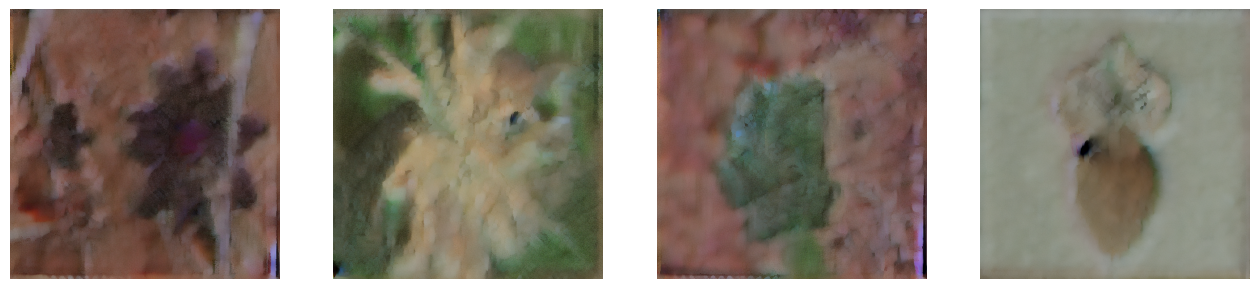

In [ ]:
decode_images = decode_latents(noise_pred)
fig, axs = plt.subplots(1, len(decode_images), figsize=(16, 4))
for i, image in enumerate(decode_images):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

## Custome_pipe

In [ ]:
from tqdm.auto import tqdm
def cust_pipe(unet, seed, eval_batch_size, scheduler):
  # generate gaussian noise to be decoded
  generator =torch.manual_seed(seed)
  batch_size = eval_batch_size #config.eval_batch_size

  noise = torch.randn(
      (batch_size, unet.in_channels, unet.sample_size, unet.sample_size),
      generator=generator).to(unet.device)

  # set inference steps for DDIM
  noise_scheduler.set_timesteps(num_inference_steps=200)

  image = noise
  for t in tqdm(noise_scheduler.timesteps):
      # predict noise residual of previous image
      with torch.no_grad():
          residual = unet(image, t)["sample"]

      # compute previous image x_t according to DDIM formula
      prev_image = noise_scheduler.step(residual, t, image)["prev_sample"]

      # x_t-1 -> x_t
      image = prev_image

  # decode image with vae
  pil_images = decode_latents(image)
  return pil_images

  0%|          | 0/200 [00:00<?, ?it/s]

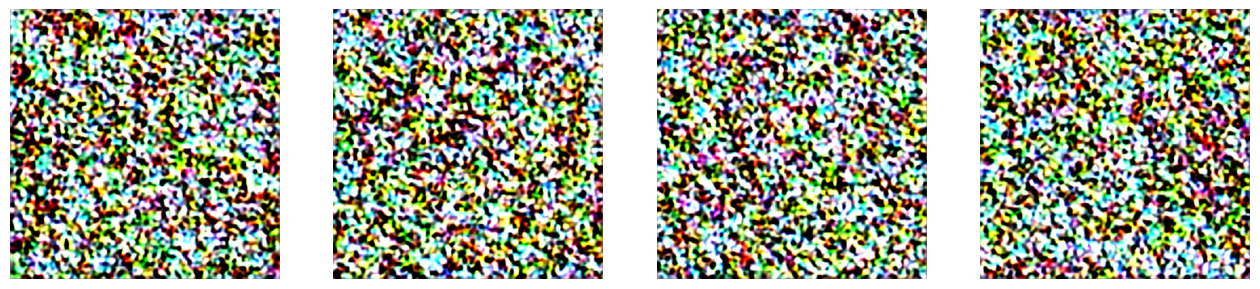

In [ ]:
pil_images = cust_pipe(model, config.seed, 4, noise_scheduler)

fig, axs = plt.subplots(1, len(pil_images), figsize=(16, 4))
for i, image in enumerate(pil_images):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

## Настройка обучения

У нас есть все необходимое для обучения нашей модели! Воспользуемся стандартным оптимизатором AdamW:

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
optimizer = accelerator.prepare(optimizer)

И косинусный scheduler:

In [ ]:
from diffusers.optimization import get_cosine_schedule_with_warmup

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

Чтобы оценить нашу модель, мы используем DDPMPipeline, который представляет собой простой способ выполнения сквозного вывода (более подробную информацию см. в этом блокноте [ссылка TODO]). Мы будем использовать этот конвейер для создания пакета образцов изображений и сохранения его в виде сетки на диск.

In [ ]:
from diffusers import DDPMPipeline #LDMSuperResolutionPipeline,
import os
import math

def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i%cols*w, i//cols*h))
    return grid


def evaluate(config, epoch, pil_images): #pipeline):
    # Сэмплируем несколько изображений из случайного шума (это обратный процесс диффузии).
    # Выход пайплайна по умолчанию - `List[PIL.Image]`
    #images = pipeline(
        #batch_size = config.eval_batch_size,
        #generator=torch.manual_seed(config.seed),
    #).images

    # Делаем сетку из изображений
    image_grid = make_grid(pil_images,
                           rows=2,
                           cols=2)

    # Сохраняем изображения
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

In [ ]:
from huggingface_hub import HfFolder, Repository, whoami

from tqdm.auto import tqdm
from pathlib import Path


def get_full_repo_name(model_id: str, organization: str = None, token: str = None):
    if token is None:
        token = HfFolder.get_token()
    if organization is None:
        username = whoami(token)["name"]
        return f"{username}/{model_id}"
    else:
        return f"{organization}/{model_id}"

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    global_step = 0

    # Теперь обучаем модель
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader))
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch['images'].to(model.device)
            #print(clean_images.shape)
            vae_images = encode_vae(clean_images).to(model.device)
            #print(vae_images.shape)
            # Сэмплируем шум чтобы добавить к изображениям
            noise = torch.randn(vae_images.shape).to(vae_images.device)
            bs = vae_images.shape[0]

            # Сэмплируем временной шаг для каждого изображений
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=vae_images.device).long()

            # Добавляем шум к чистым изображениям в соответствии с величиной шума на каждом временном шаге
            # (это процесс прямой диффузии)
            noisy_images = noise_scheduler.add_noise(vae_images, noise, timesteps)

            # Предсказываем остаток шума
            noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
            loss = F.mse_loss(noise_pred, noise)
            loss.backward()

            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            global_step += 1

        # После каждой эпохи вы при желании можете сэмплировать несколько изображений с помощью функции evaluate() и сохранить модель.
        pipeline = DDPMPipeline(unet=model, scheduler=noise_scheduler)


        if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
            pil_images = cust_pipe(model, config.seed, config.eval_batch_size, noise_scheduler)
            evaluate(config, epoch, pil_images)

        if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
            pipeline.save_pretrained(config.output_dir)

В итоге мы можем сгруппировать все вместе и написать нашу обучающую функцию. Это просто завершает этап обучения, который мы видели в предыдущем разделе.

## Давайте обучать!

Давайте запустим обучение. Перед запуском перезагрузите среду, так как у вас не хватит памяти на GPU


In [ ]:
import gc
gc.collect()

16205

In [ ]:
train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

  0%|          | 0/2048 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/2048 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/2048 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/2048 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/2048 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/2048 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/2048 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/2048 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/2048 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/2048 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/2048 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/2048 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/2048 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/2048 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/2048 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
pil_images = cust_pipe(model, config.seed, config.eval_batch_size, noise_scheduler)
evaluate(config, 0, pil_images)

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
import glob

sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
Image.open(sample_images[-1])

In [ ]:
model.save_pretrained(BASE_PATH + 'flowers-512')

Давайте посмотрим на окончательную сетку изображения, созданную обученной моделью диффузии:

In [ ]:
import glob

sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
Image.open(sample_images[-1])

### [2 балла] Анализ влияния scheduler на качество генерации

 На качество генерации может влиять используемый scheduler и число шагов, поэтому в этой части домашнего задания, вам предлагается происследовать визуально как scheduler и число шагов влияют на качество генерации. Вам предлагается рассмотреть качество генерации на 10 различных числах шагов и,  используя различные scheduler.


 В качестве scheduler предлагается стандартный DDPM, DDIM, DPMSolver (Другие scheduler не воспрещаются). Обратите внимание, что DDIM и DPMSolver являются детерминированными scheduler, а значит результат у них должен получаться одиннаковый.

 **Ожидаемый результат**

 В качестве результатов в этом пункте от вас требуется предоставить визуализации картинок в различных вариации числа шагов и scheduler и сделать выводы, какие параметры лучше использовать. Вы можете выполнить эту часть, не используя обученную выше модель, а используя стандартные pipeline StableDiffusion

In [ ]:
# your code + visualizations

### Дополнительное задание [дополнительный 1 балл]. Модификации conditional guidance*
*Дополнительный балл не умножается на коэффициент домашнего задания*

---

Далее, вам предлагается реализовать conditional guidance на этом датасете. Как уже упоминалось на лекции механизм conditional guidance позволяет вам генерировать изображения с выбранными вами условиями (картинки определенных цветков, например). На семинаре 2 был показан участок кода, который реализовал условную генерацию, однако для этого вам нужно добавить прокидывание условия в UNet и чуть поменять процесс условной генерации. При реализации вы можете опираться адаптировать следующую [реализацию](https://github.com/TeaPearce/Conditional_Diffusion_MNIST).

**Ожидаемый результат**

В качестве результатов модели, от вас требуется предоставить визуализации генераций, полученных от вашей модели, и код обучения модели.
